In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

from clean import clean_games

Let's clean & load our data. For time's sake, we're only going to use years 1990-2020.

In [2]:
game_df = clean_games("data/games_scraped.pickle", start_year=1990)

In [3]:
game_df.shape

(13118, 147)

In [4]:
pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 73)

In [5]:
# print all columns
for col_name in game_df.columns:
    print(col_name)

team
year
team_year
date
opp
week_num
decade
game_day_of_week
game_outcome
team_record
pts_off
margin
pts_def
first_down_off
yards_off
pass_yds_off
rush_yds_off
to_off
first_down_def
yards_def
pass_yds_def
rush_yds_def
to_def
game_time
overtime
team_home_game
to2_off
to2_def
game_id
result_tie
result_win
wins
losses
ties
season_week
prev_season_week
prev_wins
prev_losses
prev_ties
prev_pts_off
prev_pts_def
prev_margin
prev_first_down_off
prev_yards_off
prev_pass_yds_off
prev_rush_yds_off
prev_to_off
prev_to2_off
prev_first_down_def
prev_yards_def
prev_pass_yds_def
prev_rush_yds_def
prev_to_def
roll3_num_ties
roll3_num_wins
prev_to2_def
prev_result_tie
prev_result_win
off_bye
roll3_result_win
roll3_result_tie
roll3_pts_off
roll3_pts_def
roll3_margin
roll3_first_down_off
roll3_yards_off
roll3_pass_yds_off
roll3_rush_yds_off
roll3_to_off
roll3_to2_off
roll3_yards_def
roll3_pass_yds_def
roll3_rush_yds_def
roll3_to_def
roll3_to2_def
ewma_result_win
ewma_result_tie
ewma_pts_off
ewma_pts_def


In [6]:
# construct a list containing all of the columns we could use in model
indicators = ['prev_', 'roll3', 'ewma_']
key_variables = [col for col in game_df.columns if col[:5] in indicators]
key_variables.sort()

additional = ['year', 'date', 'team', 'team_home_game', 'opp', 'margin']

for col in additional[::-1]:
    key_variables.insert(0, col)

key_variables

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_first_down_off',
 'ewma_first_down_off_opp',
 'ewma_margin',
 'ewma_margin_opp',
 'ewma_pass_yds_def',
 'ewma_pass_yds_def_opp',
 'ewma_pass_yds_off',
 'ewma_pass_yds_off_opp',
 'ewma_pts_def',
 'ewma_pts_def_opp',
 'ewma_pts_off',
 'ewma_pts_off_opp',
 'ewma_result_tie',
 'ewma_result_win',
 'ewma_result_win_opp',
 'ewma_result_win_opp',
 'ewma_rush_yds_def',
 'ewma_rush_yds_def_opp',
 'ewma_rush_yds_off',
 'ewma_rush_yds_off_opp',
 'ewma_to2_def',
 'ewma_to2_def_opp',
 'ewma_to2_off',
 'ewma_to2_off_opp',
 'ewma_to_def',
 'ewma_to_def_opp',
 'ewma_to_off',
 'ewma_to_off_opp',
 'ewma_yards_def',
 'ewma_yards_def_opp',
 'ewma_yards_off',
 'ewma_yards_off_opp',
 'prev_first_down_def',
 'prev_first_down_def_opp',
 'prev_first_down_off',
 'prev_first_down_off_opp',
 'prev_losses',
 'prev_losses_opp',
 'prev_margin',
 'prev_margin_opp',
 'prev_pass_yds_def',
 'prev_pass_yds_def_opp',
 'prev_pass_yds_off',
 'prev_pass_y

Our DF is still too large to use `df.info()`.

Let's split the columns into sections. Since we have so many columns, we need to do quite a bit of splitting.

Let's start with a small selection of columns.

In [7]:
small_df = game_df[['margin', 'team', 'opp', 'game_id', 'year', 'roll3_margin',
                    'ewma_margin', 'roll3_to_off', 'roll3_to2_off', 'ewma_to_def', 'ewma_to2_def']]

In [8]:
indicators = ['prev_', 'roll3', 'ewma_']

prev_vars = [col for col in game_df.columns if col[:5] == 'prev_']
roll3_vars = [col for col in game_df.columns if col[:5] == 'roll3']
ewma_vars = [col for col in game_df.columns if col[:5] == 'ewma_']

# remove dupe in ewma_vars
ewma_vars = list(dict.fromkeys(ewma_vars))

for grp in [prev_vars, roll3_vars, ewma_vars]:
    for col in additional[::-1]:
        grp.insert(0, col)

prev_df = game_df[prev_vars]
roll3_df = game_df[roll3_vars]
ewma_df = game_df[roll3_vars]

In [9]:
# sns.pairplot(small_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [10]:
game_df['def_summ_test1'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to_def'].to_numpy() + 1)
      .astype(float)))

game_df['def_summ_test2'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to2_def'].to_numpy() + 1)
     .astype(float)))

def_df = game_df[['year', 'team', 'opp', 'margin', 'ewma_result_win', 'ewma_yards_def',
                  'ewma_to_def', 'ewma_to2_def', 'def_summ_test1', 'def_summ_test2']]
def_df.head(5)


,year,team,opp,margin,ewma_result_win,ewma_yards_def,ewma_to_def,ewma_to2_def,def_summ_test1,def_summ_test2
0,1990,crd,was,-28.0,0.332,321.577,1.371,3.360,135.629270,73.756193
1,1990,crd,dal,17.0,0.233,355.755,0.961,2.357,181.415094,105.974084
2,1990,crd,nyg,-1.0,0.427,291.072,1.477,4.037,117.509891,57.786778
3,1990,crd,chi,-10.0,0.332,297.740,1.593,4.029,114.824528,59.204613
4,1990,crd,mia,-20.0,0.265,314.725,1.474,3.418,127.213015,71.236985


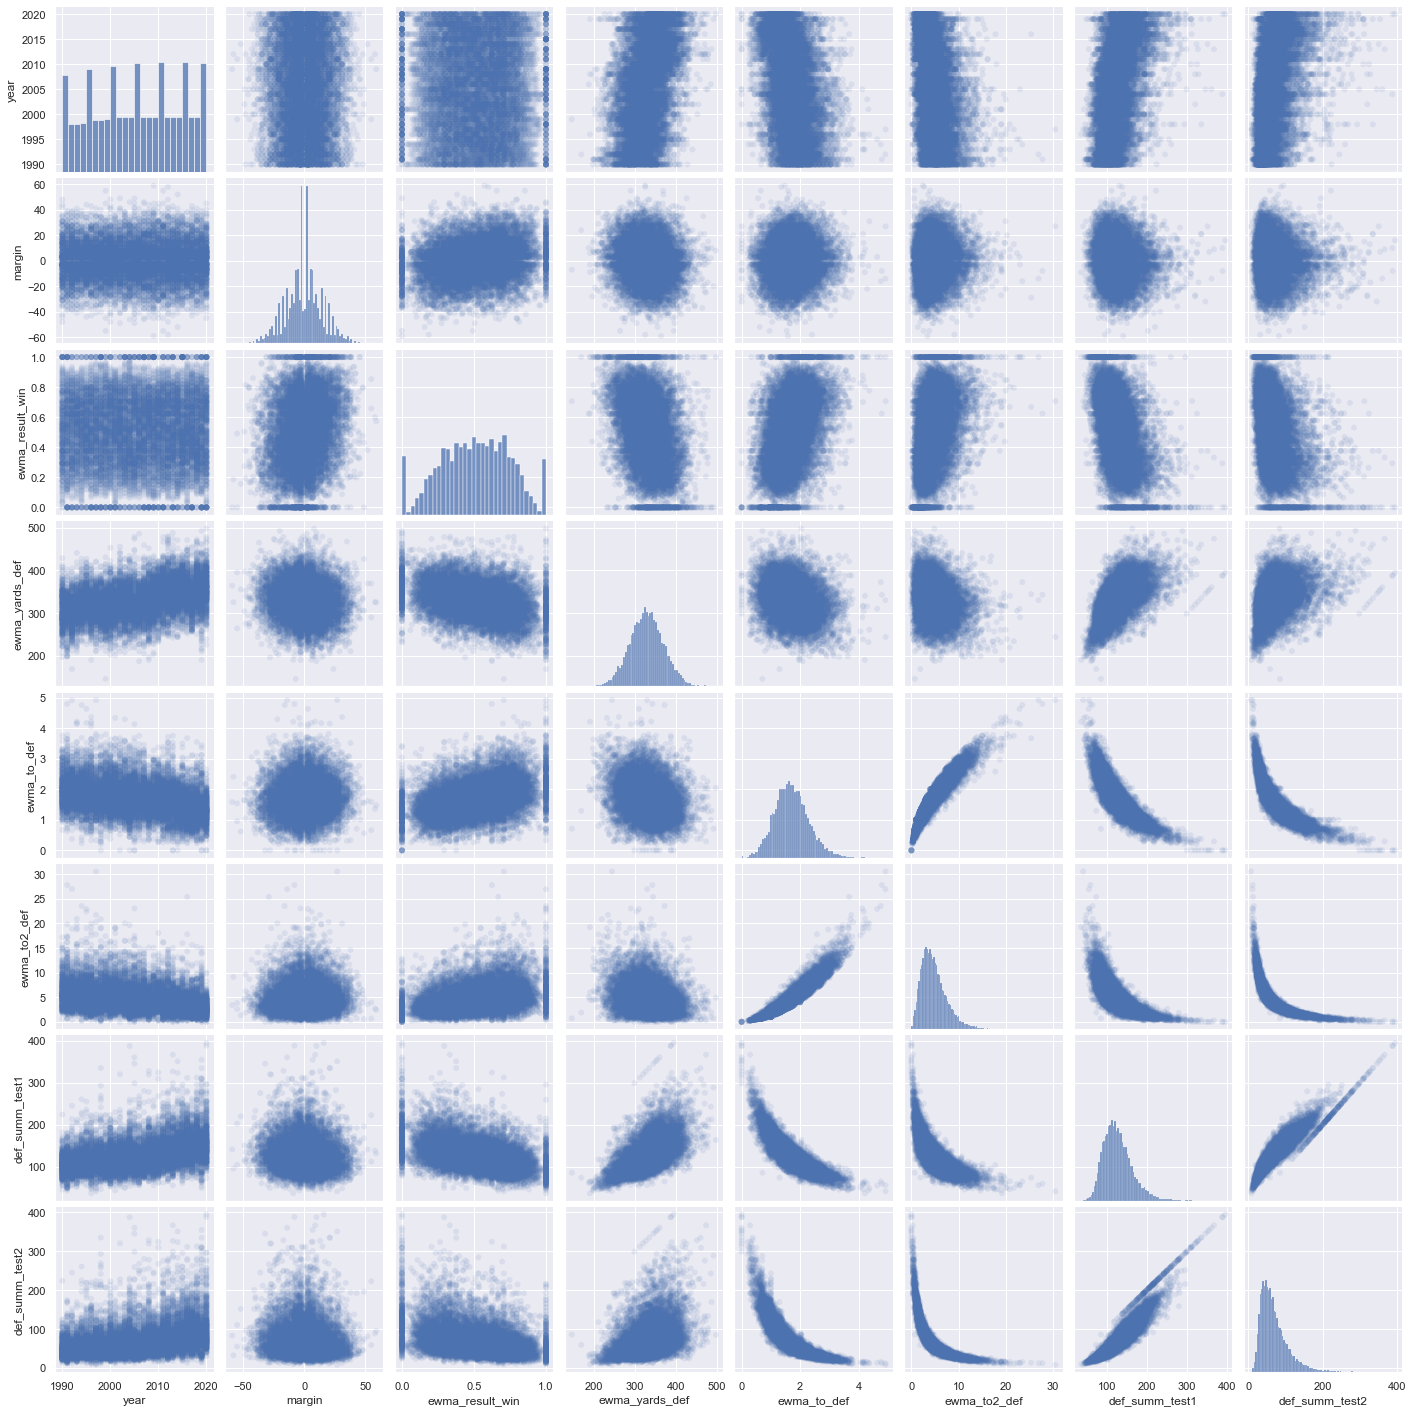

In [11]:
sns.pairplot(def_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [12]:
# new ewma cols? i.e. ewma_total_yards_off - ewma_total_yards_off_opp

# create list of all ewma vars + row indicators & remove dupes
ewma_vars
ewma_vars

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']

In [13]:
opp_ewmas = [var for var in ewma_vars if var[-4:] == '_opp']
team_ewmas = [var for var in ewma_vars[6:] if var not in opp_ewmas]

opp_ewmas.sort()
team_ewmas.sort()

In [14]:
opp_ewmas, team_ewmas

(['ewma_first_down_off_opp',
  'ewma_margin_opp',
  'ewma_pass_yds_def_opp',
  'ewma_pass_yds_off_opp',
  'ewma_pts_def_opp',
  'ewma_pts_off_opp',
  'ewma_result_win_opp',
  'ewma_rush_yds_def_opp',
  'ewma_rush_yds_off_opp',
  'ewma_to2_def_opp',
  'ewma_to2_off_opp',
  'ewma_to_def_opp',
  'ewma_to_off_opp',
  'ewma_yards_def_opp',
  'ewma_yards_off_opp'],
 ['ewma_first_down_off',
  'ewma_margin',
  'ewma_pass_yds_def',
  'ewma_pass_yds_off',
  'ewma_pts_def',
  'ewma_pts_off',
  'ewma_result_tie',
  'ewma_result_win',
  'ewma_rush_yds_def',
  'ewma_rush_yds_off',
  'ewma_to2_def',
  'ewma_to2_off',
  'ewma_to_def',
  'ewma_to_off',
  'ewma_yards_def',
  'ewma_yards_off'])

In [15]:
plot_cols = game_df.loc[:, ['ewma_margin', 'ewma_margin_opp', 'ewma_pts_off',
                'ewma_pts_def', 'ewma_pts_off_opp', 'ewma_pts_def_opp',
                'ewma_to2_off', 'ewma_to2_def', 'ewma_to2_off_opp', 'ewma_to2_def_opp',
                   'margin']]



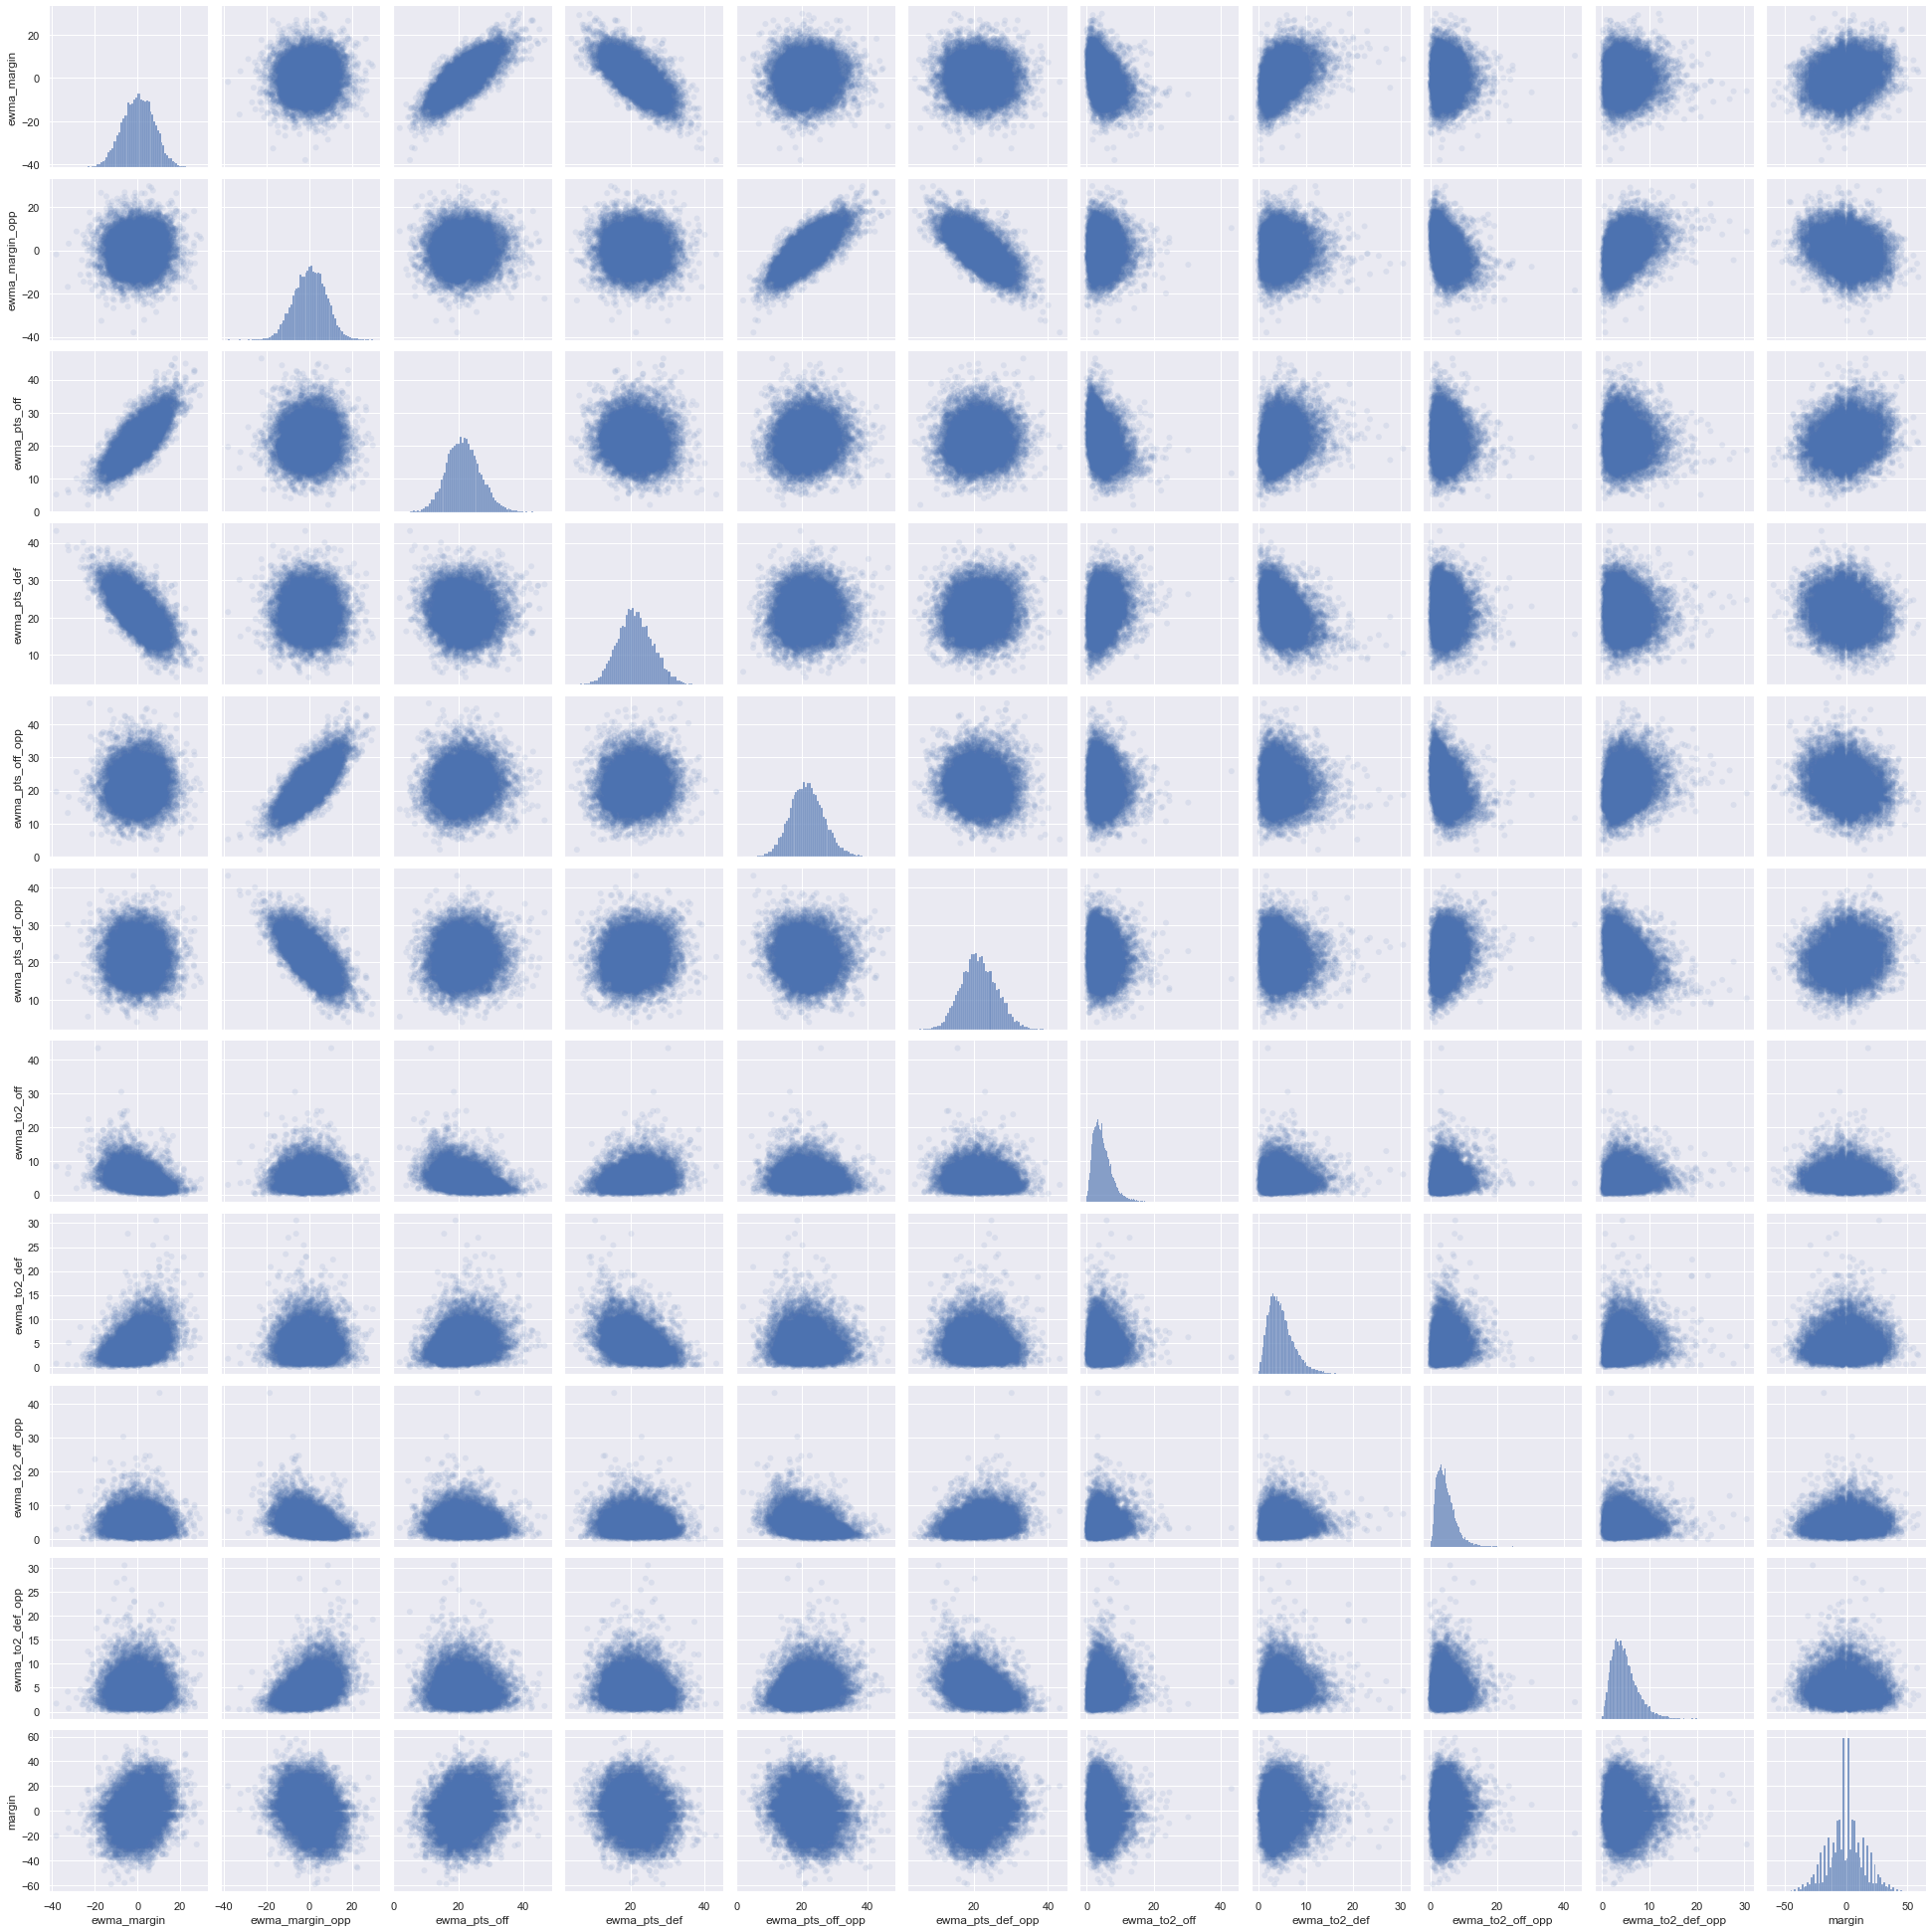

In [16]:
sns.pairplot(plot_cols, plot_kws=dict(alpha=.1, edgecolor='none'))

In [17]:
plot_cols.describe()

,ewma_margin,ewma_margin_opp,ewma_pts_off,ewma_pts_def,ewma_pts_off_opp,ewma_pts_def_opp,ewma_to2_off,ewma_to2_def,ewma_to2_off_opp,ewma_to2_def_opp,margin
count,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000,13118.000000
mean,0.343010,0.343010,21.664477,21.321460,21.664477,21.321460,4.768549,4.876062,4.768549,4.876062,0.000000
std,7.435797,7.435797,5.280971,4.766546,5.280971,4.766546,2.859050,2.835331,2.859050,2.835331,14.816002
min,-37.991000,-37.991000,2.048000,4.038000,2.048000,4.038000,0.000000,0.000000,0.000000,0.000000,-59.000000
25%,-4.720750,-4.720750,18.023250,18.051500,18.023250,18.051500,2.729000,2.860000,2.729000,2.860000,-9.000000
50%,0.443500,0.443500,21.470500,21.156500,21.470500,21.156500,4.261000,4.372500,4.261000,4.372500,0.000000
75%,5.503750,5.503750,25.032750,24.497000,25.032750,24.497000,6.226000,6.303750,6.226000,6.303750,9.000000
max,29.718000,29.718000,46.423000,43.172000,46.423000,43.172000,43.304000,30.528000,43.304000,30.528000,59.000000


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def split_and_validate(X, y):
    '''
        For a set of features and target X, y, perform a 80/20 train/val split, 
        fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

Let's try all of the roll3 columns and compare the results to ewma columns. 

In [30]:
ewma_cols = [col for col in game_df.columns if col[:4] == 'ewma']
roll3_cols = [col for col in game_df.columns if col[:4] == 'roll']

In [32]:
X = game_df[ewma_cols]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.08931370143854434
Feature coefficient results: 

ewma_result_win : 0.08
ewma_result_tie : -0.20
ewma_pts_off : 4.52
ewma_pts_def : -4.52
ewma_margin : -4.51
ewma_first_down_off : 0.01
ewma_yards_off : -1.67
ewma_pass_yds_off : 1.67
ewma_rush_yds_off : 1.67
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -17.99
ewma_pass_yds_def : 17.99
ewma_rush_yds_def : 17.99
ewma_to_def : -0.04
ewma_to2_def : -0.00
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_pts_off_opp : -2.78
ewma_pts_def_opp : 2.78
ewma_margin_opp : 2.77
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 10.91
ewma_pass_yds_off_opp : -10.91
ewma_rush_yds_off_opp : -10.91
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 14.52
ewma_pass_yds_def_opp : -14.52
ewma_rush_yds_def_opp : -14.52
ewma_to_def_opp : 0.04
ewma_to2_def_opp : -0.00


In [34]:
X = game_df[roll3_cols]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.05166396078582436
Feature coefficient results: 

roll3_num_ties : -25641809201.73
roll3_num_wins : 25641809194.76
roll3_result_win : 20.99
roll3_result_tie : -0.25
roll3_pts_off : 13.71
roll3_pts_def : -13.71
roll3_margin : -13.70
roll3_first_down_off : 0.00
roll3_yards_off : -21.50
roll3_pass_yds_off : 21.50
roll3_rush_yds_off : 21.50
roll3_to_off : -0.02
roll3_to2_off : 0.00
roll3_yards_def : 1.31
roll3_pass_yds_def : -1.31
roll3_rush_yds_def : -1.31
roll3_to_def : -0.03
roll3_to2_def : 0.00
roll3_result_win_opp : -0.08
roll3_result_tie_opp : 0.02
roll3_result_tie_opp : 0.02
roll3_result_tie_opp : 0.02
roll3_result_tie_opp : 0.02
roll3_pts_off_opp : -14.10
roll3_pts_def_opp : 14.10
roll3_margin_opp : 14.10
roll3_first_down_off_opp : -0.00
roll3_yards_off_opp : 23.11
roll3_pass_yds_off_opp : -23.12
roll3_rush_yds_off_opp : -23.11
roll3_to_off_opp : 0.01
roll3_to2_off_opp : -0.00
roll3_yards_def_opp : -3.92
roll3_pass_yds_def_opp : 3.92
roll3_rush_yds_def_o

At first glance, it appears ewma is better. Let's break them into halves to confirm.

In [35]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.04140908759270168
Feature coefficient results: 

ewma_result_win : 0.06
ewma_result_tie : -0.39
ewma_pts_off : 6.41
ewma_pts_def : -6.41
ewma_margin : -6.40
ewma_first_down_off : 0.00
ewma_yards_off : -2.82
ewma_pass_yds_off : 2.82
ewma_rush_yds_off : 2.82
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -19.21
ewma_pass_yds_def : 19.21
ewma_rush_yds_def : 19.21
ewma_to_def : -0.04
ewma_to2_def : 0.00


In [36]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.01899625262378879
Feature coefficient results: 

roll3_num_ties : -3.62
roll3_num_wins : -3.62
roll3_result_win : 21.75
roll3_result_tie : -0.35
roll3_pts_off : 17.44
roll3_pts_def : -17.44
roll3_margin : -17.44
roll3_first_down_off : -0.00
roll3_yards_off : -21.12
roll3_pass_yds_off : 21.12
roll3_rush_yds_off : 21.12
roll3_to_off : -0.02
roll3_to2_off : 0.00
roll3_yards_def : 1.38
roll3_pass_yds_def : -1.38
roll3_rush_yds_def : -1.39
roll3_to_def : -0.02


And now the other half...

In [37]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.04299174718455134
Feature coefficient results: 

ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_pts_off_opp : -5.23
ewma_pts_def_opp : 5.23
ewma_margin_opp : 5.22
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 11.34
ewma_pass_yds_off_opp : -11.34
ewma_rush_yds_off_opp : -11.34
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 17.27
ewma_pass_yds_def_opp : -17.27
ewma_rush_yds_def_opp : -17.27
ewma_to_def_opp : 0.04
ewma_to2_def_opp : -0.00


In [38]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.029675341979075176
Feature coefficient results: 

roll3_to2_def : 0.00
roll3_result_win_opp : -0.07
roll3_result_tie_opp : 0.04
roll3_result_tie_opp : 0.04
roll3_result_tie_opp : 0.04
roll3_result_tie_opp : 0.04
roll3_pts_off_opp : -17.64
roll3_pts_def_opp : 17.64
roll3_margin_opp : 17.64
roll3_first_down_off_opp : -0.00
roll3_yards_off_opp : 21.96
roll3_pass_yds_off_opp : -21.96
roll3_rush_yds_off_opp : -21.96
roll3_to_off_opp : 0.01
roll3_to2_off_opp : -0.00
roll3_yards_def_opp : -3.48
roll3_pass_yds_def_opp : 3.48
roll3_rush_yds_def_opp : 3.48
roll3_to_def_opp : 0.02
roll3_to2_def_opp : -0.00


Okay, that checks out. Moving forward, we'll use columns with the `ewma` prefix.

Let's also start factoring in home game, which we know often impacts who wins a game.

Here, we'll introduce `off_bye`, which tells us whether or not the team is coming off a bye week. Perhaps teams play better when they've had an extra week of rest time.

In [52]:
X = game_df[[
 'off_bye',
 'off_bye_opp',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.1256630831137514
Feature coefficient results: 

off_bye : 0.00
off_bye_opp : -0.00
team_home_game : 0.16
ewma_result_win : 0.08
ewma_result_tie : -0.13
ewma_pts_off : 3.92
ewma_pts_def : -3.92
ewma_margin : -3.91
ewma_first_down_off : 0.01
ewma_yards_off : -2.58
ewma_pass_yds_off : 2.58
ewma_rush_yds_off : 2.58
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -17.12
ewma_pass_yds_def : 17.12
ewma_rush_yds_def : 17.12
ewma_to_def : -0.04
ewma_to2_def : -0.00
ewma_result_win_opp : -0.04
ewma_result_win_opp : -0.04
ewma_pts_off_opp : -1.69
ewma_pts_def_opp : 1.69
ewma_margin_opp : 1.68
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 11.82
ewma_pass_yds_off_opp : -11.82
ewma_rush_yds_off_opp : -11.82
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 14.49
ewma_pass_yds_def_opp : -14.49
ewma_rush_yds_def_opp : -14.49
ewma_to_def_opp : 0.04
ewma_to2_def_opp : -0.00


In [51]:
X = game_df[[
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.12566308311361507
Feature coefficient results: 

team_home_game : 0.16
ewma_result_win : 0.08
ewma_result_tie : -0.13
ewma_pts_off : 3.92
ewma_pts_def : -3.92
ewma_margin : -3.91
ewma_first_down_off : 0.01
ewma_yards_off : -2.58
ewma_pass_yds_off : 2.58
ewma_rush_yds_off : 2.58
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -17.12
ewma_pass_yds_def : 17.12
ewma_rush_yds_def : 17.12
ewma_to_def : -0.04
ewma_to2_def : -0.00
ewma_result_win_opp : -0.04
ewma_result_win_opp : -0.04
ewma_pts_off_opp : -1.69
ewma_pts_def_opp : 1.69
ewma_margin_opp : 1.68
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 11.82
ewma_pass_yds_off_opp : -11.82
ewma_rush_yds_off_opp : -11.82
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 14.49
ewma_pass_yds_def_opp : -14.49
ewma_rush_yds_def_opp : -14.49
ewma_to_def_opp : 0.04
ewma_to2_def_opp : -0.00


Interesting... including the `off_bye` column yielded 0 impact on our $R^2$ score.

What if we used `margin` as our target (`y`) instead of W/L?

In [78]:
X = game_df[[
 'decade',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['margin']

split_and_validate(X, y)


Validation R^2 score was: 0.16828403817229165
Feature coefficient results: 

decade : 0.11
team_home_game : 5.68
ewma_result_win : 2.56
ewma_result_tie : 3.74
ewma_pts_off : 207.54
ewma_pts_def : -207.50
ewma_margin : -207.09
ewma_first_down_off : 0.29
ewma_yards_off : -60.52
ewma_pass_yds_off : 60.51
ewma_rush_yds_off : 60.51
ewma_to_off : -0.63
ewma_to2_off : 0.18
ewma_yards_def : -224.04
ewma_pass_yds_def : 224.04
ewma_rush_yds_def : 224.03
ewma_to_def : -0.64
ewma_to2_def : -0.18
ewma_result_win_opp : -1.53
ewma_result_win_opp : -1.53
ewma_pts_off_opp : -210.10
ewma_pts_def_opp : 210.14
ewma_margin_opp : 209.70
ewma_first_down_off_opp : -0.33
ewma_yards_off_opp : 255.86
ewma_pass_yds_off_opp : -255.86
ewma_rush_yds_off_opp : -255.86
ewma_to_off_opp : 1.20
ewma_to2_off_opp : -0.30
ewma_yards_def_opp : 257.64
ewma_pass_yds_def_opp : -257.65
ewma_rush_yds_def_opp : -257.64
ewma_to_def_opp : 1.09
ewma_to2_def_opp : 0.04


# Peter
- margin vs result_win as target
- feature enginering/ selection


In [75]:
plot_cols = game_df.loc[:, [
 'margin',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'margin',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'margin',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'margin',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

<ipython-input-62-d12d60e5e6b9>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(X[X.columns[10:20]], ax=ax);


TypeError: '<' not supported between instances of 'str' and 'int'

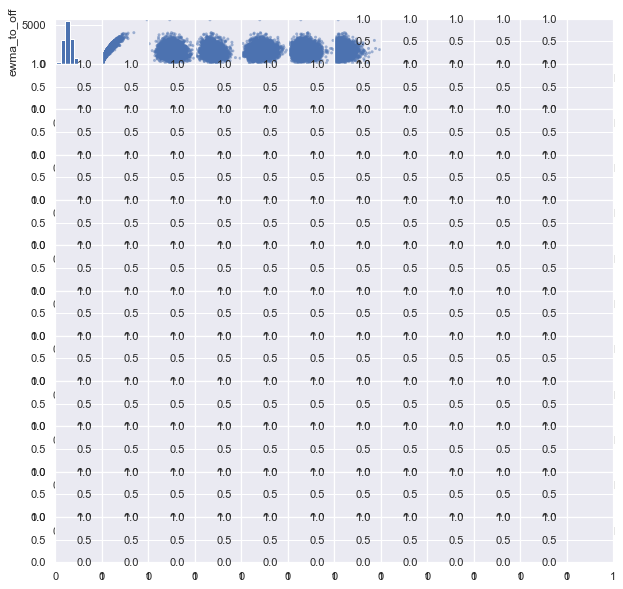

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
pd.plotting.scatter_matrix(X[X.columns[10:20]], ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
pd.plotting.scatter_matrix(X[X.columns[-6:]], ax=ax);

In [43]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=10).fit_transform(X, y)

ValueError: Input X must be non-negative.